In [1]:
# This is based on the vignette found here: https://github.com/theislab/kBET/blob/master/vignettes/kBET_vignette.Rmd

In [1]:
library(kBET)

In [2]:
pbmc <- read.table("pbmc_12k.csv", sep = ",", header = TRUE)
pbmc.labels <- read.table("pbmc_12k_batch_labels.csv", sep = ",", header = TRUE)

In [3]:
head(pbmc.labels)

batch_cov,ct_cov
0,CD4 T cells
0,CD4 T cells
0,CD14+ Monocytes
0,CD14+ Monocytes
0,CD8 T cells
0,CD4 T cells


# Look at cell-type composition between batches
This dataset contains 2 batches of PBMCs, sampled from a single donor. 
Note that the cell-type composition differs between the two batches. 

In [4]:
table(pbmc.labels$batch_cov, pbmc.labels$ct_cov)

   
    B cells CD14+ Monocytes CD4 T cells CD8 T cells Dendritic Cells
  0    1060            1483        3364         948             209
  1     561             744        1632         500             130
   
    FCGR3A+ Monocytes Megakaryocytes NK cells Other
  0               224             63      285   346
  1               127             25      172   117

In [5]:
#plot.table(table(pbmc.labels$batch_cov, pbmc.labels$ct_cov))

# kBET on "pseudo batches"
For this dataset, 1 donor was sampled in 2 batches and 9 cell types in each batch. 

Within each batch, there should be no batch effects. 
This can be shown by randomly splitting a batch into 2 "pseudo batches" and using kBET to test for evidence of batch effects.

[1] "Batch: 0"
[1] "list"
[1] "data dim: 7982" "data dim: 3346"
[1] "label dim: 7982" "label dim: 2"   
[1] "================"
  cell.type.labels.batch_cov.1   ct_cov.ct_cov
1                           gA     CD4 T cells
2                           gB     CD4 T cells
3                           gB CD14+ Monocytes
4                           gA CD14+ Monocytes
5                           gA     CD8 T cells
6                           gA     CD4 T cells
[1] TRUE
[1] "cell.type.labels.batch_cov.1" "ct_cov.ct_cov"               
[1] "================"

          B cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
              569               718              1703               480 
  Dendritic Cells FCGR3A+ Monocytes    Megakaryocytes          NK cells 
              107               100                32               138 
            Other 
              158 

          B cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
      0.142072409       0.179275905      

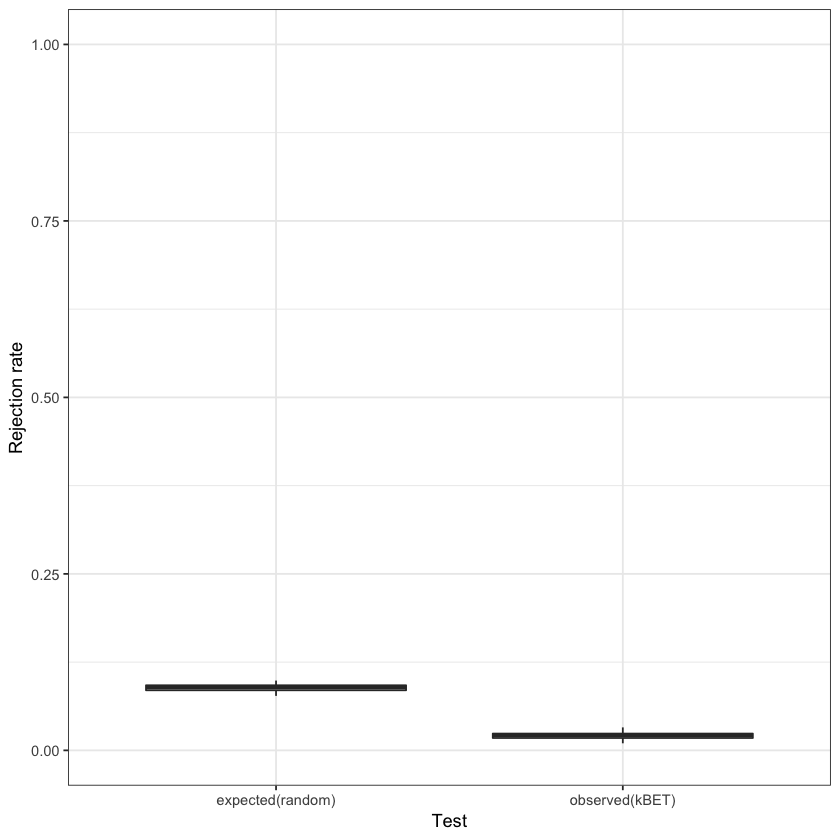

Complex study design detected.
Subset by ct_cov.ct_cov
[1] "B cells"
[1]  561 3346
[1] 561
Initial neighbourhood size is set to 210.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.473   0.038   0.238 
Number of kBET tests is set to 57.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is set to 60.
[1] "NK cells"
[1]  172 3346
[1] 172
Initial neighbourhood size is set to 64.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.065   0.008   0.018 
Number of kBET tests is set to 25.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is set to 14.
[1] "CD14+ Monocytes"
[1]  744 3346
[1] 744
Initial neighbourhood size is set to 279.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.727   0.040   0.499 
Number of kBET tests is set to 75.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is 

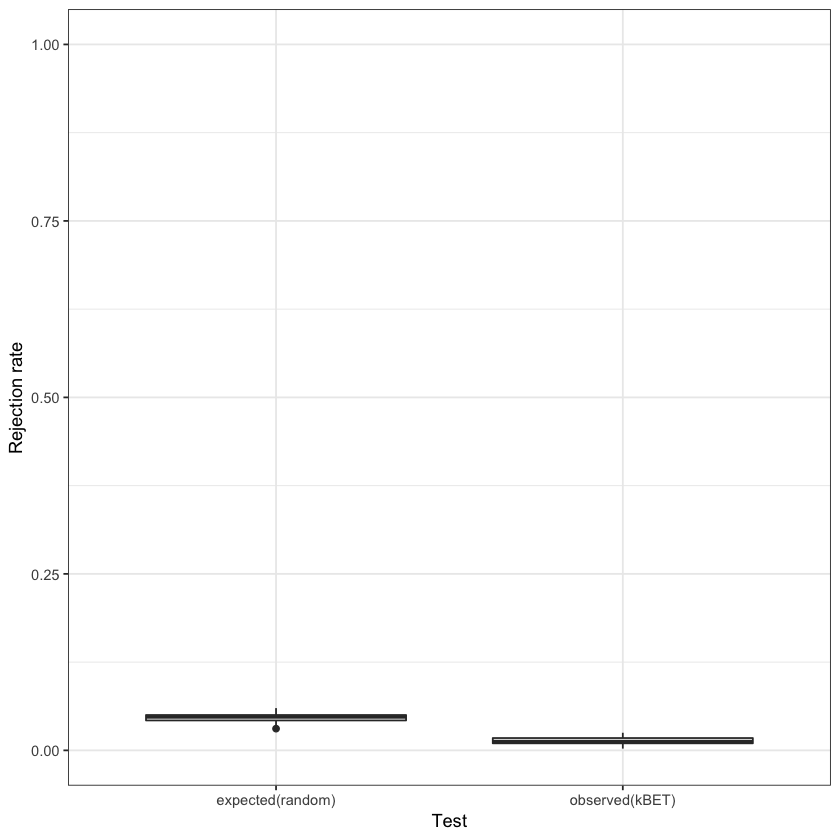

In [6]:
library(kBET)
batches <- unique(pbmc.labels$batch_cov)
cell.types <- unique(pbmc.labels$ct_cov)
kBET.counts <- list()
for (batch in batches){
    print(paste("Batch:", batch))
    
    data = pbmc[pbmc.labels$batch_cov==batch,]
    cell.type.labels = pbmc.labels[pbmc.labels$batch_cov==batch,]
    cell.type.labels = data.frame(cell.type.labels, stringsAsFactors=FALSE)
    print(typeof(cell.type.labels))
    print(paste("data dim:", dim(data)))
    print(paste("label dim:", dim(cell.type.labels)))
    

    # split sample randomly cells to create two "pseudo batches" 
    gA = sample(c(TRUE, FALSE), nrow(data), replace=TRUE, prob=c(0.5, 0.5))
    gB = !gA

    table(cell.type.labels)
    table(cell.type.labels$ct_cov[gA])
    table(cell.type.labels$ct_cov[gB])
    pseudo.batch <- list()
    pseudo.batch$batch_cov <- data.frame(cell.type.labels$batch_cov)
    pseudo.batch$cell.type.labels.batch_cov[gA] <- "gA"
    pseudo.batch$cell.type.labels.batch_cov[gB] <- "gB"
    pseudo.batch$ct_cov = cell.type.labels
    print("================")
    pseudo.batch <- data.frame(pseudo.batch)
    pseudo.batch <- pseudo.batch[,c("cell.type.labels.batch_cov.1", "ct_cov.ct_cov")]
    print(head(pseudo.batch))
    print(is.data.frame(pseudo.batch))
    print(colnames(pseudo.batch))
    print("================")
    print(table(cell.type.labels$ct_cov[gA]))
    print(table(cell.type.labels$ct_cov[gA])/length(cell.type.labels$ct_cov[gA]))
    print("================")
    print(table(cell.type.labels$ct_cov[gB]))
    print(table(cell.type.labels$ct_cov[gB])/length(cell.type.labels$ct_cov[gB]))
    
    # look only at batch labels
    kBET.results.batch <- kBET(df=data,
                               batch=pseudo.batch[[1]],
                               verbose=TRUE)
    # incorporate cell-type labels
    kBET.results <- kBET(df=data,
                         batch=pseudo.batch,
                         verbose=TRUE, 
                         plot=TRUE)
    
#     if (is.data.frame(pseudo.batch) && dim(pseudo.batch)[2]>1) {
#        cat('Complex study design detected.\n')
#        design.names <- colnames(pseudo.batch)
#        cat(paste0('Subset by ', design.names[[2]], '\n'))
#        bio <- unlist(unique(pseudo.batch[[design.names[2]]]))
#         kBET.results = list()
#         for (c in bio) {
#             print(c)
#             subset_data = data[pseudo.batch$ct_cov==c,]
#             subset_labels = pseudo.batch[pseudo.batch[2]==c,1]
#             print(dim(subset_data))
#             print(length(subset_labels))
#             kBET.results[[c]] <- kBET(df=subset_data,
#                                       batch=subset_labels,
#                                       verbose=TRUE)
#         }
#         print(bio[1])
#       #drop subset batch
#        new.batch <- base::subset(pseudo.batch,
#       pseudo.batch[[2]]== bio[1])[,!design.names %in% design.names[[2]]]
#         print(head(new.batch))
#         print(dim(data[pseudo.batch[[2]]==bio[1],]))
#        sapply(data[pseudo.batch[[2]]==bio[1],], kBET, new.batch,
#       k0, knn, testSize, heuristic,n_repeat, alpha, addTest, verbose)
#    }
    
#     kBET.counts[[batch+1]] <- kBET(df = data, 
#                                    batch=pseudo.batch, 
#                                    plot=FALSE)
}

In [7]:
kBET.results.nobatch = kBET.results

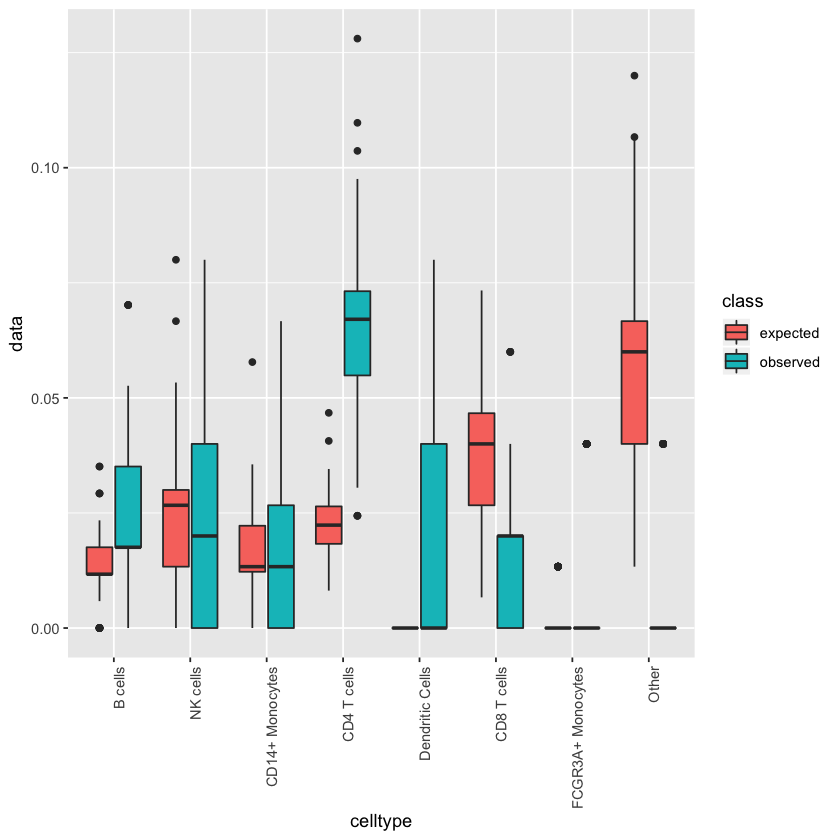

In [8]:
library(ggplot2)
library(gridExtra)
kBET.plots <- list()
plot.data <- data.frame()
for (ct in names(kBET.results)){
  plot.data <- rbind(plot.data,
                     data.frame(class = rep(c('observed', 'expected'), each=100), 
                          data = c(kBET.results.nobatch[[ct]]$stats$kBET.observed,
                                   kBET.results.nobatch[[ct]]$stats$kBET.expected),
                          celltype = rep(ct, each=200))
                     )
#   kBET.plots[[ct]] <- ggplot(plot.data, aes(class, data)) + 
#                               geom_boxplot() + 
#                               theme_bw() + 
#                               labs(x='Test', y='Rejection rate',title=paste("", ct)) + 
#                               scale_y_continuous(limits=c(0,1))
}

ggplot(data=plot.data, aes(x=celltype, y=data)) + geom_boxplot(aes(fill=class)) + theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [9]:
for (cell in names(kBET.results.nobatch)) {
    print(cell)
    print(kBET.results.nobatch[[cell]]$summary)
}

[1] "B cells"
      kBET.expected kBET.observed kBET.signif
mean     0.01374269    0.02385965 0.446017293
2.5%     0.00000000    0.00000000 0.001222927
50%      0.01169591    0.01754386 0.428901650
97.5%    0.02923977    0.07017544 1.000000000
[1] "NK cells"
      kBET.expected kBET.observed kBET.signif
mean     0.02346667         0.022   0.6817650
2.5%     0.00000000         0.000   0.1702958
50%      0.02666667         0.020   0.8868520
97.5%    0.05333333         0.080   1.0000000
[1] "CD14+ Monocytes"
      kBET.expected kBET.observed kBET.signif
mean    0.016444444    0.01466667 0.624323015
2.5%    0.004444444    0.00000000 0.001498312
50%     0.013333333    0.01333333 0.699967903
97.5%   0.031111111    0.05333333 1.000000000
[1] "CD4 T cells"
      kBET.expected kBET.observed  kBET.signif
mean     0.02278455    0.06536585 0.0395522406
2.5%     0.01112805    0.02728659 0.0000000000
50%      0.02235772    0.06707317 0.0001063608
97.5%    0.03455285    0.10076220 0.3758788781
[1] "D

In [10]:
# library(ggplot2)
# library(gridExtra)
# kBET.plots <- list()
# for (batch in batches){
#   plot.data <- data.frame(class = rep(c('observed', 'expected'), each=200), 
#                           data = c(kBET.counts[[batch+1]]$stats$kBET.observed,
#                                    kBET.counts[[batch+1]]$stats$kBET.expected))
#   kBET.plots[[batch+1]] <- ggplot(plot.data, aes(class, data)) + 
#                               geom_boxplot() + 
#                               theme_bw() + 
#                               labs(x='Test', y='Rejection rate',title=paste("Batch: ", batch)) + 
#                               scale_y_continuous(limits=c(0,1))
# }
# n <- length(kBET.plots)
# do.call("grid.arrange", c(kBET.plots, ncol=n))

# kBET on "pseudo batches" while changing cell-type composition
As before, we split each batch into "pseudo batches" but now we split the batch into 2 "pseudo batches" 
such that each "pseudo batch" has a different cell type composition. As this data still originates from the same batch, 
kBET should not detect evidence of a batch effect. 

In [11]:
print(table(pbmc.labels$ct_cov))


          B cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
             1621              2227              4996              1448 
  Dendritic Cells FCGR3A+ Monocytes    Megakaryocytes          NK cells 
              339               351                88               457 
            Other 
              463 


[1] "Batch: 0"
[1] "list"
[1] "data dim: 7982" "data dim: 3346"
[1] "label dim: 7982" "label dim: 2"   
[1] "group size: 3364"
[1] "batch 0 cell type CD4 T cells split: 2483"
[1] "group size: 1483"
[1] "batch 0 cell type CD14+ Monocytes split: 1236"
[1] "group size: 948"
[1] "batch 0 cell type CD8 T cells split: 55"
[1] "group size: 1060"
[1] "batch 0 cell type B cells split: 282"
[1] "group size: 346"
[1] "batch 0 cell type Other split: 219"
[1] "group size: 209"
[1] "batch 0 cell type Dendritic Cells split: 65"
[1] "group size: 224"
[1] "batch 0 cell type FCGR3A+ Monocytes split: 189"
[1] "group size: 285"
[1] "batch 0 cell type NK cells split: 204"
[1] "group size: 63"
[1] "batch 0 cell type Megakaryocytes split: 22"
[1] "================"
  cell.type.labels.batch_cov.1   ct_cov.ct_cov
1                           gA     CD4 T cells
2                           gA     CD4 T cells
3                           gA CD14+ Monocytes
4                           gA CD14+ Monocytes
5           

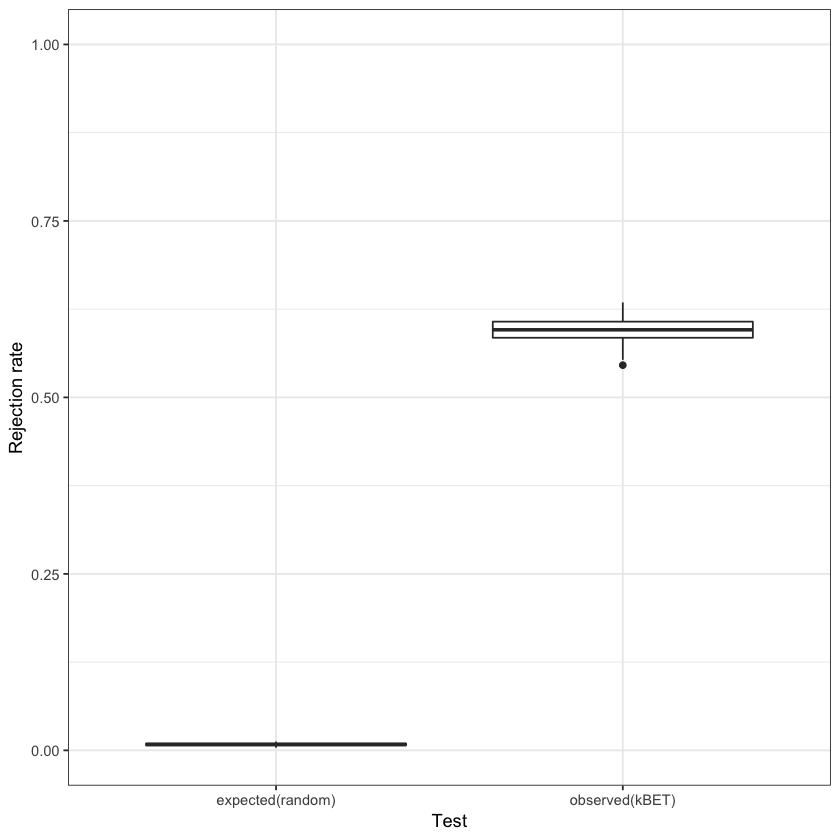

Complex study design detected.
Subset by ct_cov.ct_cov
[1] "B cells"
[1]  561 3346
[1] 561
Initial neighbourhood size is set to 210.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.471   0.037   0.234 
Number of kBET tests is set to 57.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is set to 60.
[1] "NK cells"
[1]  172 3346
[1] 172
Initial neighbourhood size is set to 64.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.062   0.008   0.018 
Number of kBET tests is set to 25.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is set to 14.
[1] "CD14+ Monocytes"
[1]  744 3346
[1] 744
Initial neighbourhood size is set to 279.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.728   0.039   0.494 
Number of kBET tests is set to 75.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is 

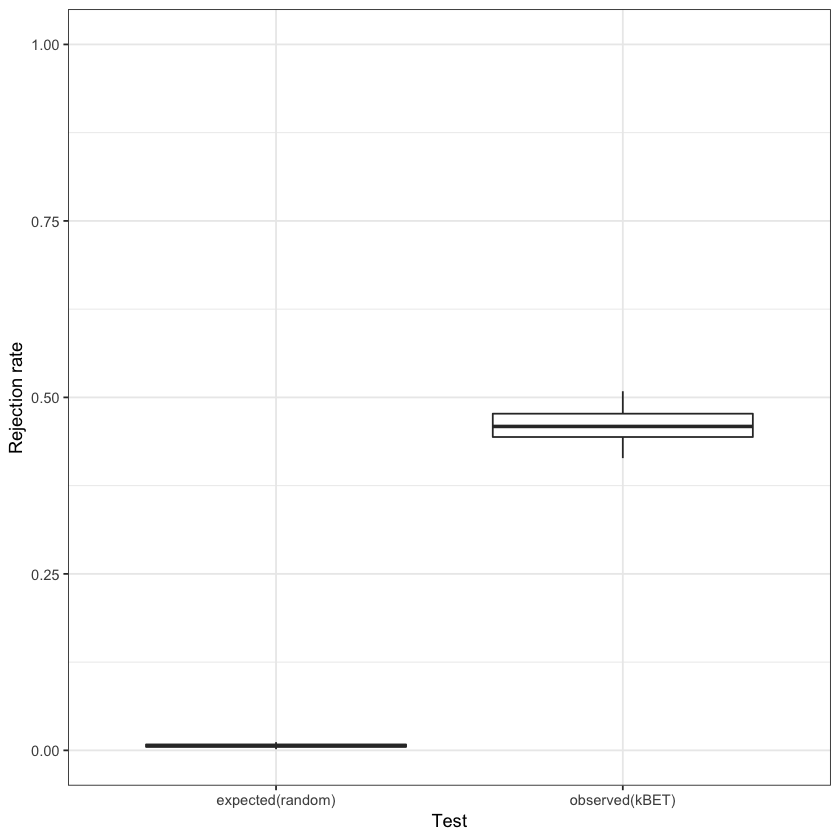

In [12]:
library(kBET)
batches <- unique(pbmc.labels$batch_cov)
cell.types <- unique(pbmc.labels$ct_cov)
kBET.counts <- list()
for (batch in batches){
    print(paste("Batch:", batch))
    
    data = pbmc[pbmc.labels$batch_cov==batch,]
    cell.type.labels = pbmc.labels[pbmc.labels$batch_cov==batch,]
    cell.type.labels = data.frame(cell.type.labels, stringsAsFactors=FALSE)
    print(typeof(cell.type.labels))
    print(paste("data dim:", dim(data)))
    print(paste("label dim:", dim(cell.type.labels)))
    
    gA = c()
    gB = c()
    # for each cell type, unevenly sample so that cell-type composition 
    # is different between different "pseudo-batches"
    for (c in cell.types) {
        group.len = length(which(cell.type.labels$ct_cov == c))
        # may want to check threshold for number of cells, and skip cell types with small number of cells
        print(paste("group size:", group.len))
        split.val = sample(20:group.len-20, 1)
        print(paste("batch", batch, "cell type", c, "split:", split.val), sep=" ")
        gA = c(gA, which(cell.type.labels$ct_cov == c)[1:split.val])
        gB = c(gB, which(cell.type.labels$ct_cov == c)[-(1:split.val)])
    }  
    
    table(cell.type.labels)
    table(cell.type.labels$ct_cov[gA])
    table(cell.type.labels$ct_cov[gB])
    pseudo.batch <- list()
    pseudo.batch$batch_cov <- data.frame(cell.type.labels$batch_cov)
    pseudo.batch$cell.type.labels.batch_cov[gA] <- "gA"
    pseudo.batch$cell.type.labels.batch_cov[gB] <- "gB"
    pseudo.batch$ct_cov = cell.type.labels
    print("================")
    pseudo.batch <- data.frame(pseudo.batch)
    pseudo.batch <- pseudo.batch[,c("cell.type.labels.batch_cov.1", "ct_cov.ct_cov")]
    print(head(pseudo.batch))
    print(is.data.frame(pseudo.batch))
    print(table(pseudo.batch))
    print("================")
    print(table(cell.type.labels$ct_cov[gA]))
    print(table(cell.type.labels$ct_cov[gA])/length(cell.type.labels$ct_cov[gA]))
    print("================")
    print(table(cell.type.labels$ct_cov[gB]))
    print(table(cell.type.labels$ct_cov[gB])/length(cell.type.labels$ct_cov[gB]))
    
    # look only at batch labels
    kBET.results.batch <- kBET(df=data,
                               batch=pseudo.batch[[1]],
                               verbose=TRUE)
    # incoroporate cell-type labels
    kBET.results <- kBET(df=data,
                         batch=pseudo.batch,
                         verbose=TRUE)
    
#     if (is.data.frame(pseudo.batch) && dim(pseudo.batch)[2]>1) {
#        cat('Complex study design detected.\n')
#        design.names <- colnames(pseudo.batch)
#        cat(paste0('Subset by ', design.names[[2]], '\n'))
#        bio <- unlist(unique(pseudo.batch[[design.names[2]]]))
#         kBET.results = list()
#         for (c in bio) {
#             print(c)
#             subset_data = data[pseudo.batch$ct_cov==c,]
#             subset_labels = pseudo.batch[pseudo.batch[2]==c,1]
#             print(dim(subset_data))
#             print(length(subset_labels))
#             kBET.results[[c]] <- kBET(df=subset_data,
#                                       batch=subset_labels,
#                                       verbose=TRUE, adapt=FALSE)
#         }
#     }
    
    
#     kBET.counts[[batch+1]] <- kBET(df = data, 
#                                    batch=pseudo.batch, 
#                                    plot=FALSE)
}

In [13]:
for (cell in names(kBET.results)) {
    print(cell)
    print(kBET.results[[cell]]$summary)
}

[1] "B cells"
      kBET.expected kBET.observed kBET.signif
mean    0.021988304    0.03333333 0.378867497
2.5%    0.005847953    0.00000000 0.002588994
50%     0.023391813    0.03508772 0.318128014
97.5%   0.044005848    0.08771930 1.000000000
[1] "NK cells"
      kBET.expected kBET.observed kBET.signif
mean     0.04920000        0.0488 0.561498596
2.5%     0.01333333        0.0000 0.001807668
50%      0.04000000        0.0400 0.590818968
97.5%    0.09333333        0.1200 1.000000000
[1] "CD14+ Monocytes"
      kBET.expected kBET.observed kBET.signif
mean     0.06453333    0.03053333   0.8396881
2.5%     0.04000000    0.00000000   0.2988881
50%      0.06666667    0.02666667   0.9074803
97.5%    0.09566667    0.06666667   1.0000000
[1] "CD4 T cells"
      kBET.expected kBET.observed  kBET.signif
mean    0.008434959    0.01164634 4.914321e-01
2.5%    0.002032520    0.00000000 1.424744e-05
50%     0.008130081    0.01219512 4.404317e-01
97.5%   0.014227642    0.03048780 1.000000e+00
[1] "D

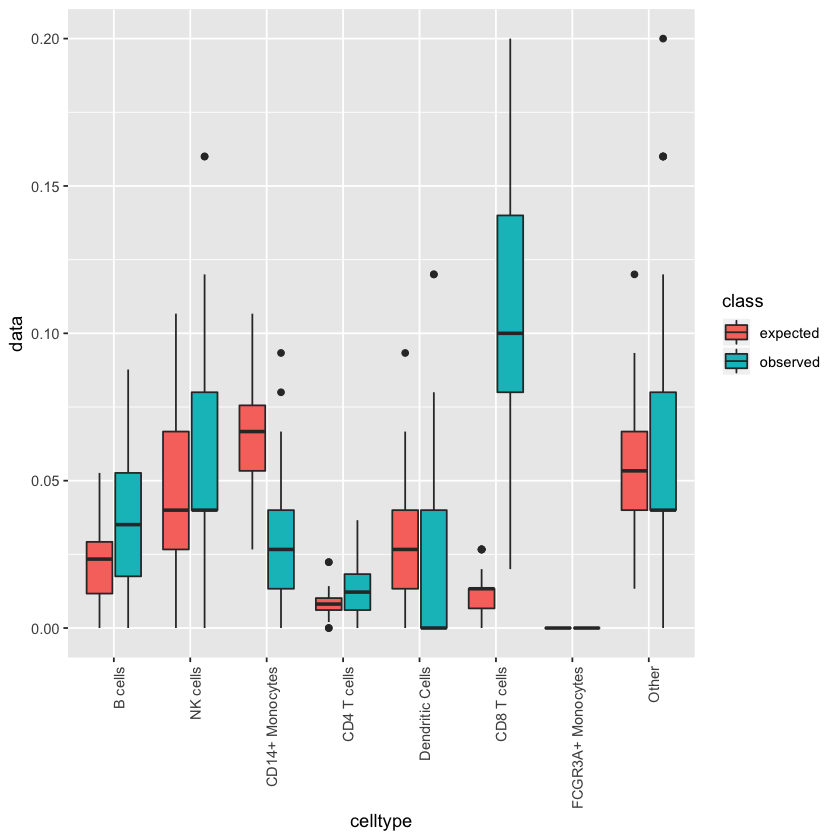

In [14]:
library(ggplot2)
library(gridExtra)
kBET.plots <- list()
plot.data <- data.frame()
for (ct in names(kBET.results)){
  plot.data <- rbind(plot.data,
                     data.frame(class = rep(c('observed', 'expected'), each=100), 
                          data = c(kBET.results[[ct]]$stats$kBET.observed,
                                   kBET.results[[ct]]$stats$kBET.expected),
                          celltype = rep(ct, each=200))
                     )
#   kBET.plots[[ct]] <- ggplot(plot.data, aes(class, data)) + 
#                               geom_boxplot() + 
#                               theme_bw() + 
#                               labs(x='Test', y='Rejection rate',title=paste("", ct)) + 
#                               scale_y_continuous(limits=c(0,1))
}

ggplot(data=plot.data, aes(x=celltype, y=data)) + geom_boxplot(aes(fill=class)) + theme(axis.text.x = element_text(angle = 90, hjust = 1))

# n <- length(kBET.plots)
# do.call("grid.arrange", c(kBET.plots, ncol=n))

In [ ]:
# library(ggplot2)
# library(gridExtra)
# kBET.plots <- list()
# for (batch in batches){
#   plot.data <- data.frame(class = rep(c('observed', 'expected'), each=100), 
#                           data = c(kBET.counts[[batch+1]]$stats$kBET.observed,
#                                    kBET.counts[[batch+1]]$stats$kBET.expected))
#   kBET.plots[[batch+1]] <- ggplot(plot.data, aes(class, data)) + 
#                               geom_boxplot() + 
#                               theme_bw() + 
#                               labs(x='Test', y='Rejection rate',title=paste("Batch: ", batch)) + 
#                               scale_y_continuous(limits=c(0,1))
# }
# n <- length(kBET.plots)
# do.call("grid.arrange", c(kBET.plots, ncol=n))

# Run kBET to see initial batch effect

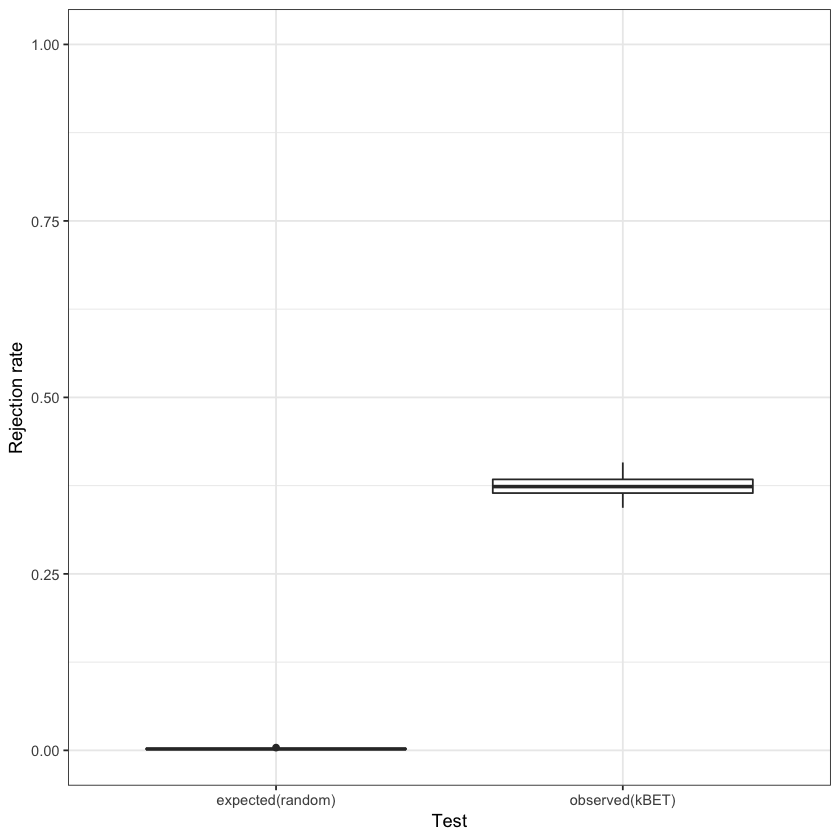

In [5]:
kBET.results <- kBET(df=pbmc,
                     batch=pbmc.labels$batch_cov)

In [6]:
kBET.results$summary

,kBET.expected,kBET.observed,kBET.signif
mean,0.0020795107,0.3734529,0
2.5%,0.0008340284,0.3481026,0
50%,0.0019460662,0.3736447,0
97.5%,0.0034820684,0.3970809,0


Complex study design detected.
Subset by ct_cov
[1] "CD4 T cells"
[1] 4996 3346
[1] 4996
Initial neighbourhood size is set to 1873.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
 72.077   0.283  72.281 
Number of kBET tests is set to 500.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is set to 1175.
[1] "CD14+ Monocytes"
[1] 2227 3346
[1] 2227
Initial neighbourhood size is set to 835.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  8.111   0.066   7.919 
Number of kBET tests is set to 223.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is set to 680.
[1] "CD8 T cells"
[1] 1448 3346
[1] 1448
Initial neighbourhood size is set to 543.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  2.710   0.046   2.509 
Number of kBET tests is set to 145.
Determining optimal neighbourhood size ...done.
New size of neighb

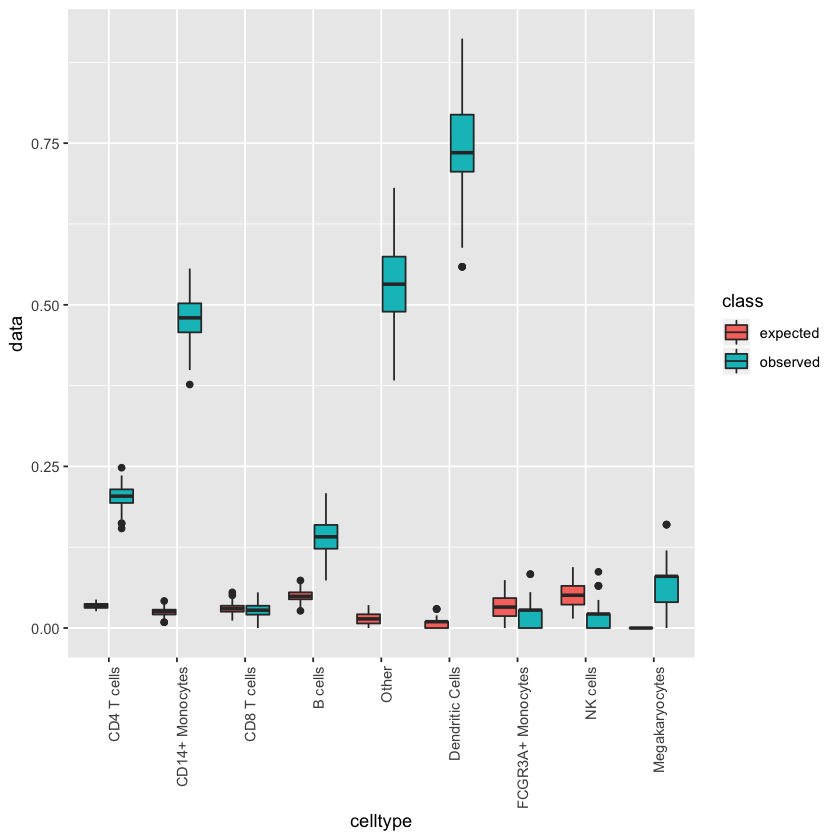

In [4]:
pre.cca.kBET.results <- kBET(df=pbmc,
                            batch=pbmc.labels, 
                            verbose=TRUE)

In [44]:
for (cell in names(pre.cca.kBET.results)) {
    print(cell)
    print(pre.cca.kBET.results[[cell]]$summary)
}

[1] "CD4 T cells"
      kBET.expected kBET.observed kBET.signif
mean     0.02122667       0.20692           0
2.5%     0.01565000       0.18000           0
50%      0.02133333       0.20600           0
97.5%    0.02866667       0.23600           0
[1] "CD14+ Monocytes"
      kBET.expected kBET.observed kBET.signif
mean    0.004035874     0.4783408           0
2.5%    0.000000000     0.4236547           0
50%     0.004484305     0.4798206           0
97.5%   0.008968610     0.5336323           0
[1] "CD8 T cells"
      kBET.expected kBET.observed kBET.signif
mean     0.03650575   0.026482759  0.68885527
2.5%     0.02178161   0.006896552  0.05210575
50%      0.03678161   0.027586207  0.75276716
97.5%    0.05057471   0.048275862  0.99055956
[1] "B cells"
      kBET.expected kBET.observed  kBET.signif
mean     0.02443763    0.12036810 4.038095e-05
2.5%     0.01431493    0.07361963 0.000000e+00
50%      0.02453988    0.11963190 2.220446e-16
97.5%    0.03788344    0.17177914 1.935090e-04
[1]

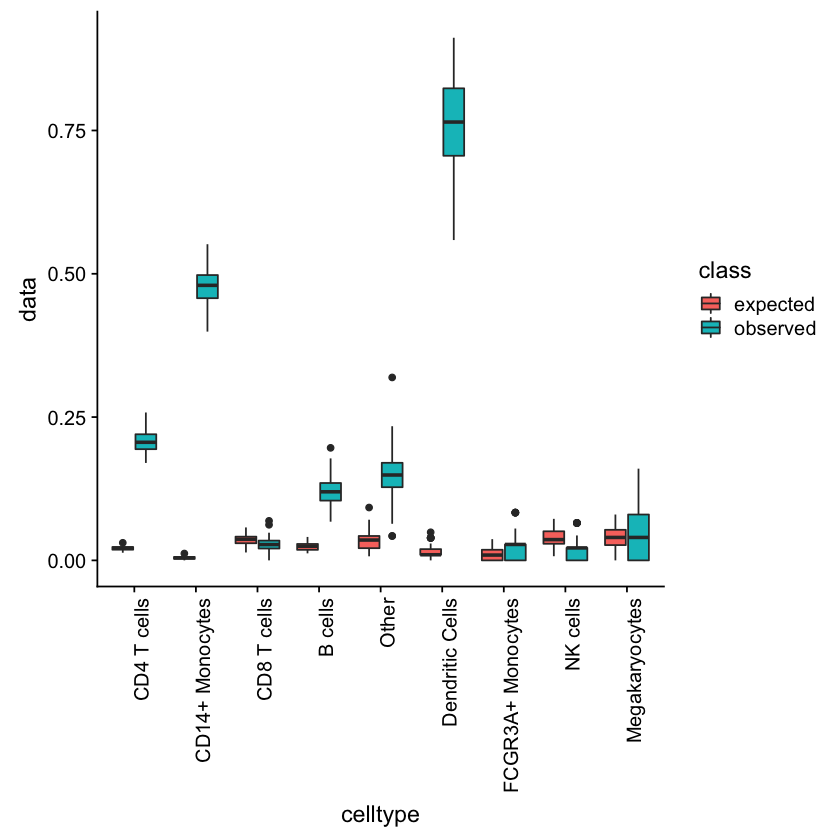

In [45]:
library(ggplot2)
library(gridExtra)
kBET.plots <- list()
plot.data <- data.frame()
for (ct in names(pre.cca.kBET.results)){
  plot.data <- rbind(plot.data,
                     data.frame(class = rep(c('observed', 'expected'), each=100), 
                          data = c(pre.cca.kBET.results[[ct]]$stats$kBET.observed,
                                   pre.cca.kBET.results[[ct]]$stats$kBET.expected),
                          celltype = rep(ct, each=200))
                     )
#   kBET.plots[[ct]] <- ggplot(plot.data, aes(class, data)) + 
#                               geom_boxplot() + 
#                               theme_bw() + 
#                               labs(x='Test', y='Rejection rate',title=paste("", ct)) + 
#                               scale_y_continuous(limits=c(0,1))
}

ggplot(data=plot.data, aes(x=celltype, y=data)) + geom_boxplot(aes(fill=class)) + theme(axis.text.x = element_text(angle = 90, hjust = 1))

# n <- length(kBET.plots)
# do.call("grid.arrange", c(kBET.plots, ncol=n))

# Use Seurat to remove batch effect

In [7]:
library(Seurat)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix


In [8]:
ctrl.data <- pbmc[pbmc.labels$batch_cov == 0, 1:ncol(pbmc)]
stim.data <- pbmc[pbmc.labels$batch_cov == 1, 1:ncol(pbmc)]

In [9]:
ctrl.data <- t(ctrl.data)
stim.data <- t(stim.data)

In [10]:
# Set up control object
ctrl <- CreateSeuratObject(raw.data = ctrl.data, project = "IMMUNE_CTRL", min.cells = 5)
ctrl@meta.data$stim <- "CTRL"
ctrl <- FilterCells(ctrl, subset.names = "nGene", low.thresholds = 500, high.thresholds = Inf)
ctrl <- NormalizeData(ctrl)
ctrl <- ScaleData(ctrl)
# Set up stimulated object
stim <- CreateSeuratObject(raw.data = stim.data, project = "IMMUNE_STIM", min.cells = 5)
stim@meta.data$stim <- "STIM"
stim <- FilterCells(stim, subset.names = "nGene", low.thresholds = 500, high.thresholds = Inf)
stim <- NormalizeData(stim)
stim <- ScaleData(stim)

Scaling data matrix
Scaling data matrix


In [11]:
# Gene selection for input to CCA
ctrl <- FindVariableGenes(ctrl, do.plot = F)
stim <- FindVariableGenes(stim, do.plot = F)
g.1 <- head(rownames(ctrl@hvg.info), 1000)
g.2 <- head(rownames(stim@hvg.info), 1000)
genes.use <- unique(c(g.1,g.2))
genes.use <- intersect(genes.use, rownames(ctrl@scale.data))
genes.use <- intersect(genes.use, rownames(stim@scale.data))

In [12]:
# Run CCA
immune.combined <- RunCCA(ctrl, stim, genes.use = genes.use, num.cc = 30)

Scaling data matrix


Scaling data matrix
Scaling data matrix


  |======================================================================| 100%


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


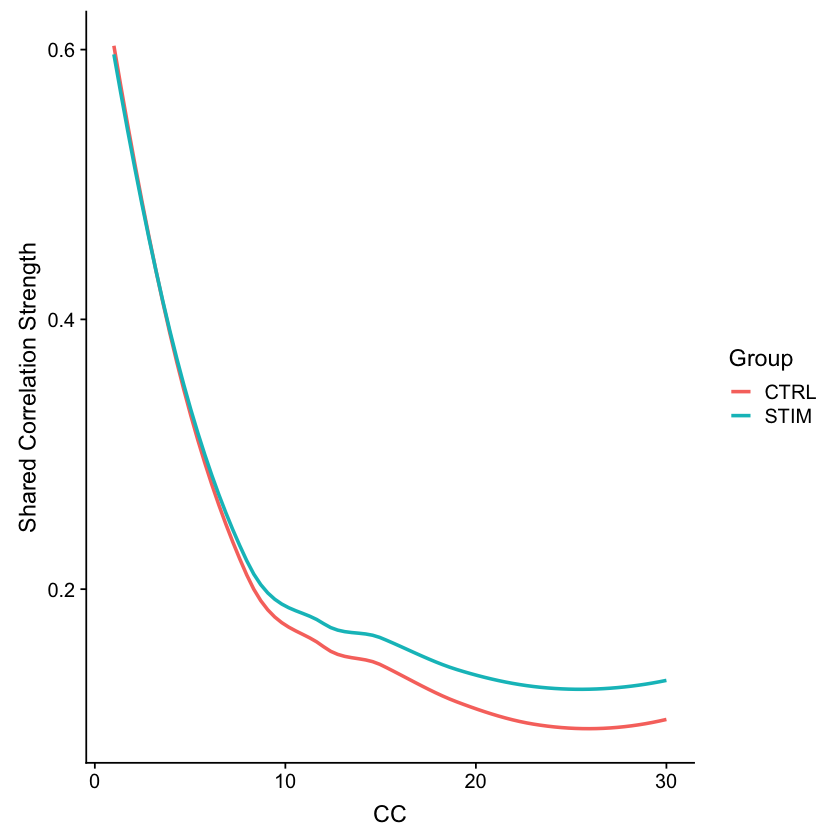

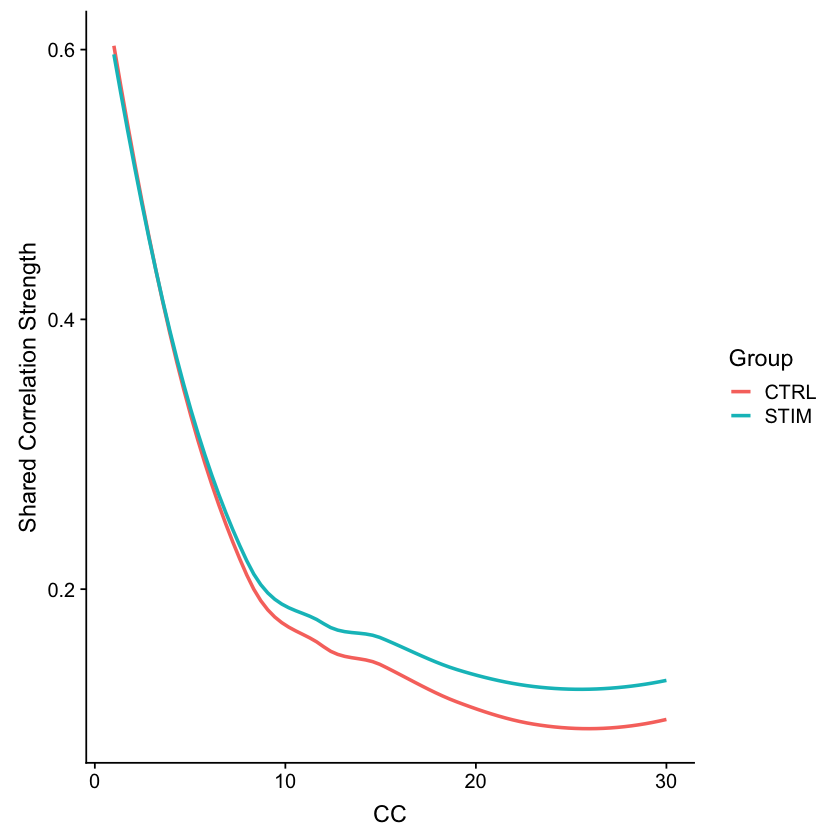

In [13]:
# CC Selection
MetageneBicorPlot(immune.combined, grouping.var = "stim", dims.eval = 1:30)

In [14]:
# Run rare non-overlapping filtering (no cells detected here as expected)
immune.combined <- CalcVarExpRatio(immune.combined, reduction.type = "pca", grouping.var = "orig.ident", dims.use = 1:20)

In [15]:
# Alignment
immune.combined <- AlignSubspace(immune.combined, reduction.type = "cca", grouping.var = "orig.ident", dims.align = 1:20)

Scaling data matrix
Scaling data matrix


In [16]:
# https://github.com/satijalab/seurat/blob/65b77a9480281ef9ab1aa8816f7c781752092c18/R/alignment.R#L299
alignment.score <- CalcAlignmentMetric(immune.combined, reduction.use = "cca.aligned",
                    dims.use = 1:20, grouping.var = "orig.ident")
sprintf("alignment score: %f", alignment.score)

[1] "alignment score: 0.905580"

In [17]:
immune.combined <- RunTSNE(immune.combined, reduction.use = "cca.aligned", dims.use = 1:20, 
    do.fast = T)
immune.combined <- FindClusters(immune.combined, reduction.type = "cca.aligned", 
    resolution = 0.6, dims.use = 1:20)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3095
Number of edges: 193663

Running Louvain algorithm...
Random start: 1
Iteration: 1
Modularity: 0.8569
Iteration: 2
Modularity: 0.8571
Iteration: 3
Modularity: 0.8571

Random start: 2
Iteration: 1
Modularity: 0.8570
Iteration: 2
Modularity: 0.8571
Iteration: 3
Modularity: 0.8571

Random start: 3
Iteration: 1
Modularity: 0.8569
Iteration: 2
Modularity: 0.8571
Iteration: 3
Modularity: 0.8571

Random start: 4
Iteration: 1
Modularity: 0.8568
Iteration: 2
Modularity: 0.8571
Iteration: 3
Modularity: 0.8571

Random start: 5
Iteration: 1
Modularity: 0.8568
Iteration: 2
Modularity: 0.8571
Iteration: 3
Modularity: 0.8571

Random start: 6
Iteration: 1
Modularity: 0.8570
Iteration: 2
Modularity: 0.8571
Iteration: 3
Modularity: 0.8571

Random start: 7
Iteration: 1
Modularity: 0.8568
Iteration: 2
Modularity: 0.8571
Iteration: 3
Modularity: 0.8571

Random start: 8
Iteration: 1
Modularity: 0.8568
Iteration: 2

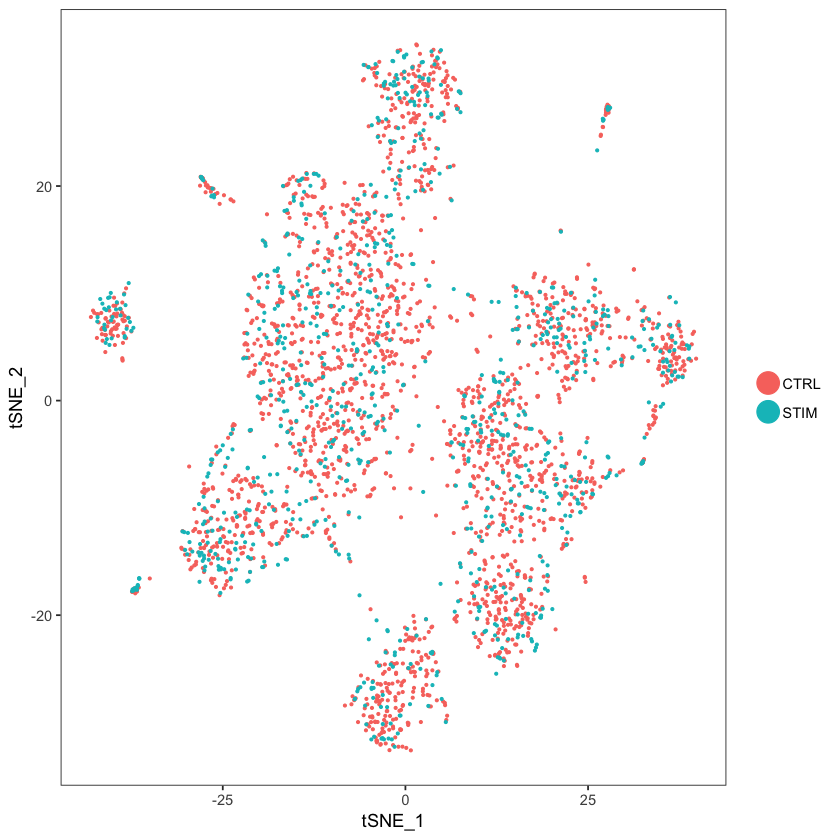

In [18]:
p1 <- TSNEPlot(immune.combined, do.return = T, pt.size = 0.5, group.by = "stim")
plot(p1)

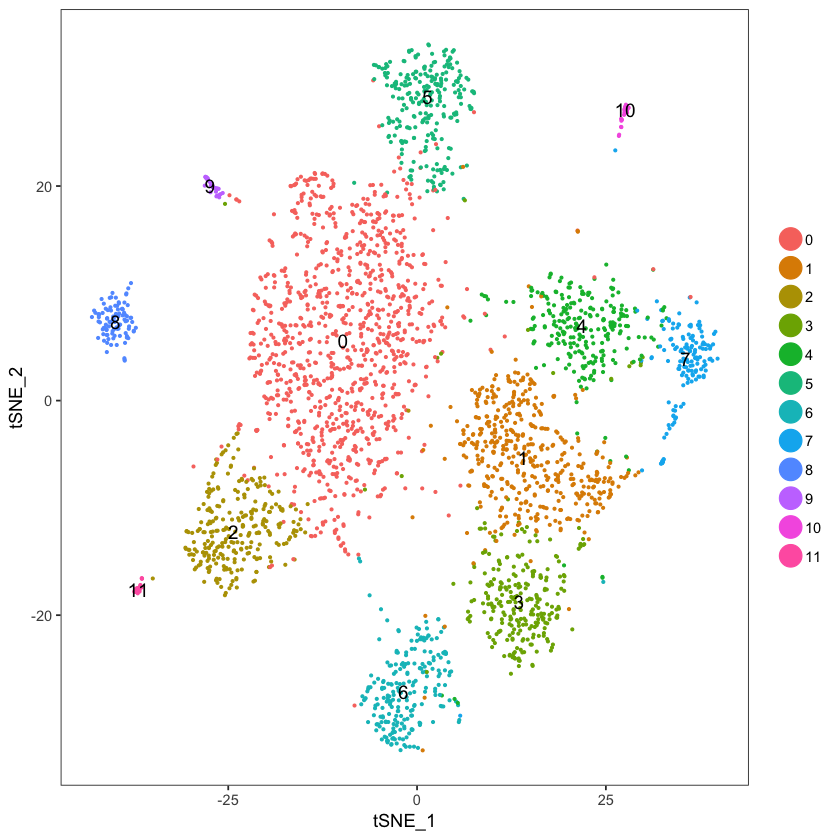

In [19]:
p2 <- TSNEPlot(immune.combined, do.label = T, do.return = T, pt.size = 0.5)
plot(p2)

In [20]:
# get projection of cells onto low-dim space
d <- GetCellEmbeddings(object = immune.combined, reduction.type = "cca")

In [21]:
batch_labels <- immune.combined@meta.data$orig.ident

In [22]:
table(batch_labels)

batch_labels
IMMUNE_CTRL IMMUNE_STIM 
       2203         892 

In [23]:
table(immune.combined@meta.data$res.0.6)


   0    1   10   11    2    3    4    5    6    7    8    9 
1034  452   29   25  267  266  260  253  227  152   98   32 

# Run kBET to see removed batch effect

In [24]:
k0 = min(table(pbmc.labels$batch_cov, pbmc.labels$ct_cov))
print(k0)

[1] 25


finding knns...done. Time:
   user  system elapsed 
  1.983   0.010   2.002 
Number of kBET tests is set to 310.


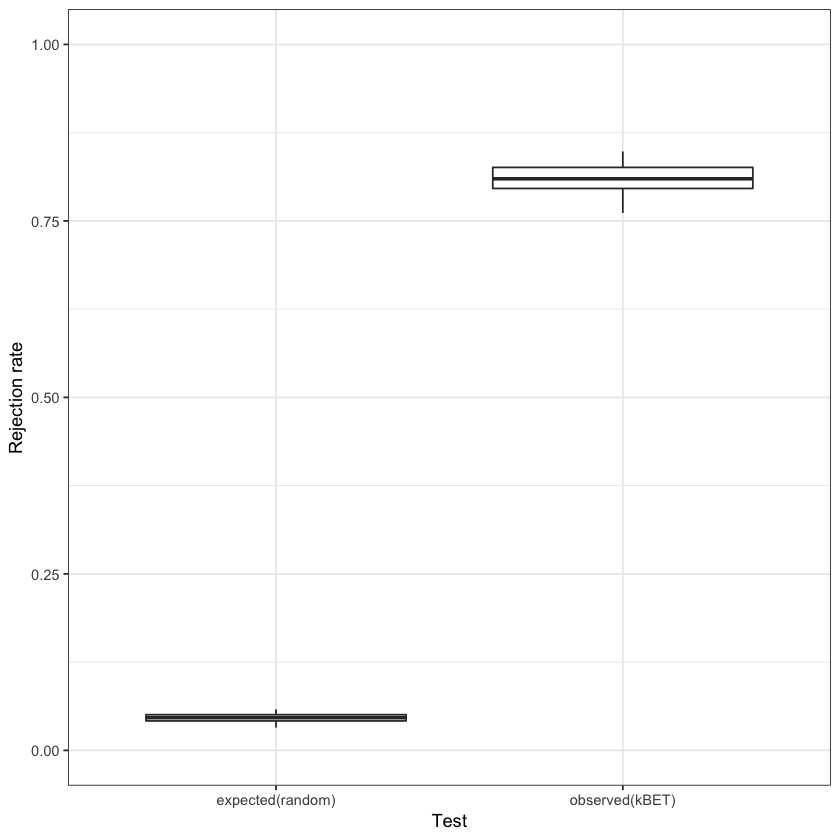

In [25]:
batch.estimate <- kBET(d, batch_labels, do.pca=FALSE, verbose=TRUE, k0=k0, n_repeat=20, adapt=FALSE)

In [26]:
batch.estimate$summary

,kBET.expected,kBET.observed,kBET.signif
mean,0.04559140,0.8085484,0
2.5%,0.03430108,0.7704839,0
50%,0.04623656,0.8096774,0
97.5%,0.05602151,0.8422581,0


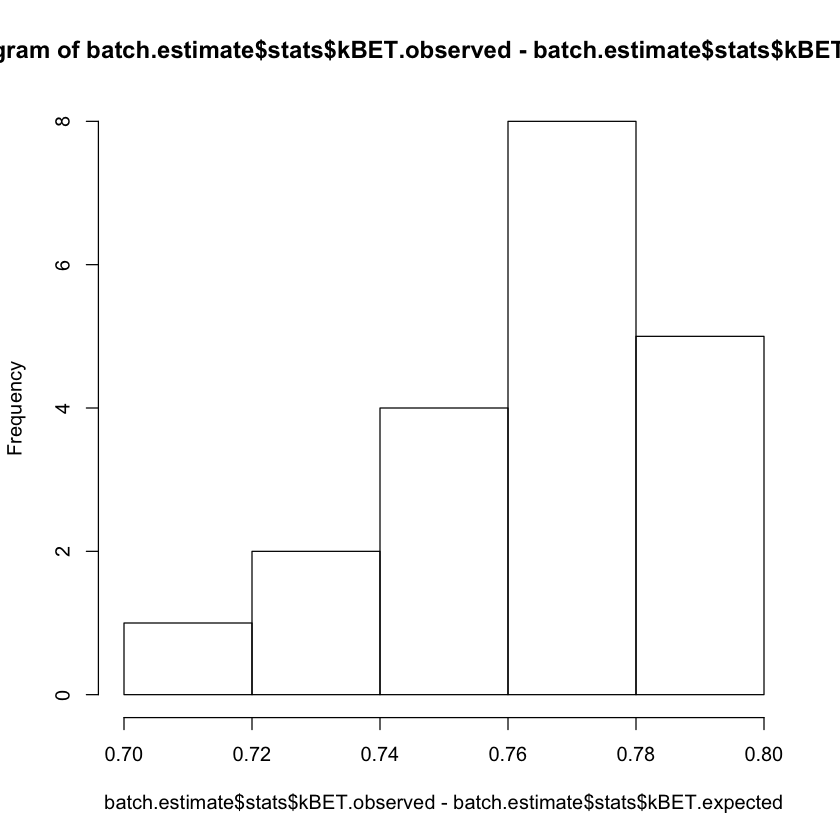

In [31]:
hist(batch.estimate$stats$kBET.observed - batch.estimate$stats$kBET.expected)

In [39]:
cca.cell.labels = pbmc.labels[as.numeric(rownames(d)),]

In [40]:
cca.kBET.results <- kBET(df=d, 
                        batch=cca.cell.labels,
                        verbose=TRUE)

Complex study design detected.
Subset by ct_cov
[1] "CD14+ Monocytes"
[1] 775  30
[1] 775
Initial neighbourhood size is set to 290.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.653   0.045   0.427 
Number of kBET tests is set to 78.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is set to 290.
[1] "CD4 T cells"
[1] 704  30
[1] 704
Initial neighbourhood size is set to 264.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.565   0.038   0.327 
Number of kBET tests is set to 71.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is set to 264.
[1] "Dendritic Cells"
[1] 329  30
[1] 329
Initial neighbourhood size is set to 123.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.200   0.026   0.057 
Number of kBET tests is set to 33.
Determining optimal neighbourhood size ...done.
New size of neighbourhood is

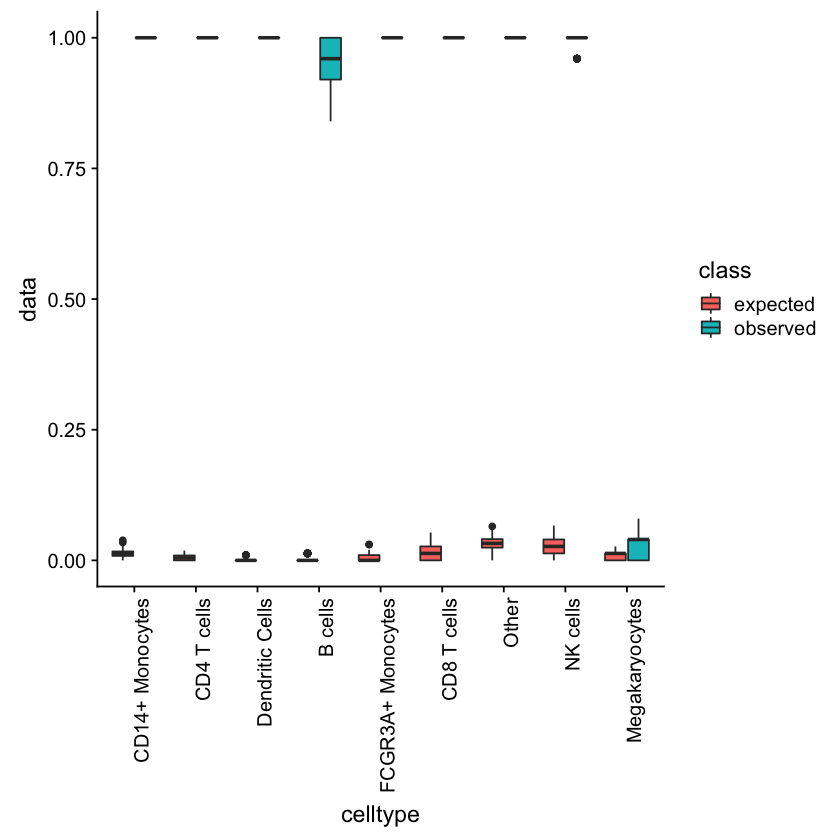

In [41]:
library(ggplot2)
library(gridExtra)
kBET.plots <- list()
plot.data <- data.frame()
for (ct in names(cca.kBET.results)){
  plot.data <- rbind(plot.data,
                     data.frame(class = rep(c('observed', 'expected'), each=100), 
                          data = c(cca.kBET.results[[ct]]$stats$kBET.observed,
                                   cca.kBET.results[[ct]]$stats$kBET.expected),
                          celltype = rep(ct, each=200))
                     )
#   kBET.plots[[ct]] <- ggplot(plot.data, aes(class, data)) + 
#                               geom_boxplot() + 
#                               theme_bw() + 
#                               labs(x='Test', y='Rejection rate',title=paste("", ct)) + 
#                               scale_y_continuous(limits=c(0,1))
}

ggplot(data=plot.data, aes(x=celltype, y=data)) + geom_boxplot(aes(fill=class)) + theme(axis.text.x = element_text(angle = 90, hjust = 1))

# n <- length(kBET.plots)
# do.call("grid.arrange", c(kBET.plots, ncol=n))

In [42]:
for (cell in names(cca.kBET.results)) {
    print(cell)
    print(cca.kBET.results[[cell]]$summary)
}

[1] "CD14+ Monocytes"
      kBET.expected kBET.observed kBET.signif
mean     0.01329060             1           0
2.5%     0.00000000             1           0
50%      0.01282051             1           0
97.5%    0.02991453             1           0
[1] "CD4 T cells"
      kBET.expected kBET.observed kBET.signif
mean    0.004929577             1           0
2.5%    0.000000000             1           0
50%     0.004694836             1           0
97.5%   0.014084507             1           0
[1] "Dendritic Cells"
      kBET.expected kBET.observed kBET.signif
mean   0.0007070707             1           0
2.5%   0.0000000000             1           0
50%    0.0000000000             1           0
97.5%  0.0101010101             1           0
[1] "B cells"
      kBET.expected kBET.observed kBET.signif
mean    0.002933333         0.956           0
2.5%    0.000000000         0.880           0
50%     0.000000000         0.960           0
97.5%   0.013333333         1.000           0
[1] 